In [1]:
# following to "Clustering product names" note:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
#nltk.download('popular') # this needs to run only once to download various tokenizers etc

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans

# following to "ML NLP text classification..." note:

# this does magic with words
# from sklearn.feature_extraction.text import CountVectorizer
# transforms the results of previous magic
from sklearn.feature_extraction.text import TfidfTransformer 
# automatic subdivision dataset to train/test data with changing parts
from sklearn.model_selection import cross_val_score
# Naive Bayes classifyer
from sklearn.naive_bayes import MultinomialNB

In [2]:
# useful links:
# https://towardsdatascience.com/clustering-product-names-with-python-part-1-f9418f8705c8 (VPN needed)
# https://towardsdatascience.com/clustering-product-names-with-python-part-2-648cc54ca2ac
# https://stackoverflow.com/questions/56840573/python-sklearn-how-to-get-clusters-and-cluster-names-after-doing-kmeans
# https://machinelearningmastery.ru/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a/

In [3]:
df = pd.read_csv('data.csv', header=None, usecols=[1,2])
df.rename(columns={1:'description',2:'category'}, inplace=True)
df.columns

Index(['description', 'category'], dtype='object')

In [4]:
df.shape

(574, 2)

In [5]:
df.head(20)

,description,category
0,Suva Svinjska Pecenica Matijevic Slajs 100G,semi-finished products
1,Panceta Matijevic Slajs 150G,semi-finished products
2,Pršuta Slajs Martex 100G,semi-finished products
3,Suvi Vrat Martex 100G,semi-finished products
4,Sunka Pik Vrbovec Fina 150G,semi-finished products
5,Zimska salama Pik Vrbovec 100g,semi-finished products
6,Prsut Majstor mesar lovcenski slajs 100g,semi-finished products
7,Prsut Pik Vrbovec Dalmatinski 100G,semi-finished products
8,Cajna Kobasica Matijevic Slajs 100G,semi-finished products
9,Cajna Kobasica Goranovic Slajs 100G,semi-finished products


In [18]:
# here goes some preprocessing
text1 = df.description.apply(lambda x: x.lower())
# remove stopwords, punctuation and numbers
text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1]

In [89]:
# in the original note then goes stemming, but currently I see no signs that we need it here, maybe it will change later
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

# text3 = text2 #for stemming, change to: pd.Series([stemSentence(x) for x in text2]) but currently in changes nothing

In [97]:
pd.DataFrame(pd.concat([pd.Series(text1), pd.Series(text2)], axis=1))

,description,0
0,suva svinjska pecenica matijevic slajs 100g,suva svinjska pecenica matijevic slajs g
1,panceta matijevic slajs 150g,panceta matijevic slajs g
2,pršuta slajs martex 100g,pršuta slajs martex g
3,suvi vrat martex 100g,suvi vrat martex g
4,sunka pik vrbovec fina 150g,sunka pik vrbovec fina g
...,...,...
569,domaća oblanda 350g slatko srce (142946),domaća oblanda g slatko srce
570,vanilice 450g slatko srce (142949),vanilice g slatko srce
571,ruske kape 450g slatko srce (146073),ruske kape g slatko srce
572,francuski makaronsi 24 kom 288g chateau blanc ...,francuski makaronsi kom g chateau blanc


In [111]:
# removing colors might be helpful, but in current data...
# they ALL ARE IN CHERNOGORIAN (wchich is not Serbian but somewhere close enough)
# quick manual analysis:
# ['bijeli', 'bijela', 'bijelo', 'crni', 'crna', 'crno', 'crveni', 'crvena', 'crveno', 'zlatni', 'zeleni', 'zelena', 'žuti', 'žuta']

# list of stop words for vectorizer
# colors in Chernogorian
sw_cernogor = ['bijeli', 'bijela', 'bijelo', 
                       'crni', 'crna', 'crno', 
                       'crveni', 'crvena', 'crveno', 
                       'zlatni', 'zeleni', 'zelena', 
                       'žuti', 'žuta', 'white'] # yes there are two names with 'white'!!!
# units (i hope they are quite international otherwise we need to top up this list)
sw_units = ['kg', 'g', 'ml', 'l', 'cl', 'mm']

<BarContainer object of 17 artists>

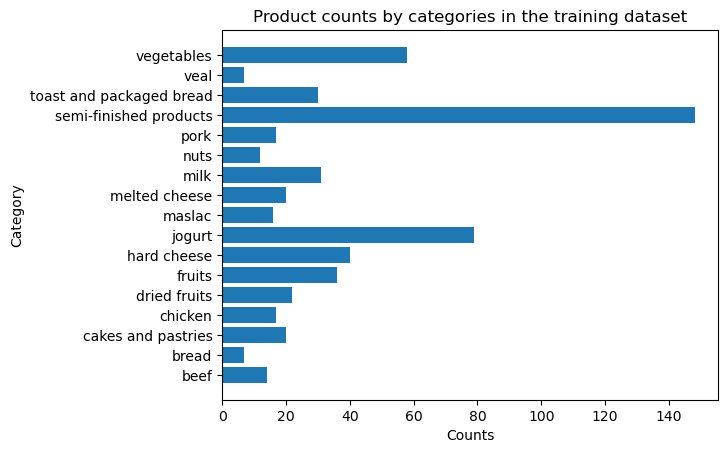

In [112]:
# let's look how much elements of various categories we have
cat_counts = df.groupby(['category'], as_index=False).count().rename(columns={'description':'count'})
fig_categ_stats, ax_cs = plt.subplots(figsize=(6.4,4.8))
ax_cs.set_xlabel('Counts')
ax_cs.set_ylabel('Category')
ax_cs.set_title('Product counts by categories in the training dataset')
ax_cs.barh(cat_counts['category'], cat_counts['count'])

In [126]:
# service cell for investigation of the data
df[df.description.apply(lambda x: 'jagoda' in x)]
#df[(df.category=='vegetables')|(df.category=='fruits')].head(100)
#df[df.category=='dried fruits']

,description,category,description_upd
146,Vocni jogurt Jogobella musli jagoda banana 200g,jogurt,vocni jogurt jogobella musli jagoda banana
328,Voćni jogurt Jogood jagoda 330g,jogurt,voćni jogurt jogood jagoda
493,Proteinski napitak jagoda 0.5 l Zbregov (160151),jogurt,proteinski napitak jagoda zbregov


In [120]:
text3 = [remove_stopwords(x, stopwords=sw_cernogor+sw_units) for x in text2]
df['description_upd'] = pd.Series(text3)
df

,description,category,description_upd
0,Suva Svinjska Pecenica Matijevic Slajs 100G,semi-finished products,suva svinjska pecenica matijevic slajs
1,Panceta Matijevic Slajs 150G,semi-finished products,panceta matijevic slajs
2,Pršuta Slajs Martex 100G,semi-finished products,pršuta slajs martex
3,Suvi Vrat Martex 100G,semi-finished products,suvi vrat martex
4,Sunka Pik Vrbovec Fina 150G,semi-finished products,sunka pik vrbovec fina
...,...,...,...
569,Domaća oblanda 350g Slatko srce (142946),cakes and pastries,domaća oblanda slatko srce
570,Vanilice 450g Slatko srce (142949),cakes and pastries,vanilice slatko srce
571,Ruske kape 450g Slatko srce (146073),cakes and pastries,ruske kape slatko srce
572,Francuski makaronsi 24 kom 288g Chateau Blanc ...,cakes and pastries,francuski makaronsi kom chateau blanc


In [157]:
vector_cv = CountVectorizer(
                            #token_pattern=r'[a-z]+', 
                            analyzer='word', 
                            strip_accents='unicode'
                            # min_df = 2, max_df = 8,
                            #stop_words = sw_cernogor+sw_units
                            ) # created the vectorizer
X_tot_cv = vector_cv.fit_transform(df.description_upd) # making word vectors out of our product names

vector_cv.get_feature_names_out()
# from here we see that stemming still necessary, but in cernogorian language!
# currently just work as is, deal with it later

array(['abata', 'abc', 'aia', 'ajdara', 'ajdared', 'ala', 'alpska',
       'ambrosi', 'ananas', 'argeta', 'aroma', 'avokado', 'babura',
       'baby', 'badem', 'badembrusnica', 'baget', 'bajadera', 'balans',
       'balansobrok', 'banana', 'barena', 'barilla', 'base', 'basta',
       'bastensko', 'batak', 'batat', 'bauletto', 'bayernland', 'baza',
       'belje', 'berny', 'bez', 'bianco', 'bilje', 'biscott', 'biser',
       'blanc', 'blitva', 'bonesa', 'brasnom', 'breskvice', 'brisaola',
       'brokoli', 'brokula', 'brusnica', 'budimska', 'bugarske',
       'buterom', 'butkice', 'butter', 'cabata', 'cacao', 'cajna',
       'campina', 'carnex', 'carre', 'carrefioco', 'carska', 'casa',
       'casica', 'cekin', 'celer', 'cepa', 'cepom', 'cevapi', 'chateau',
       'cheddar', 'cimet', 'classic', 'classico', 'cokolada', 'cokoladni',
       'company', 'conad', 'crnogorska', 'cuor', 'cupavci', 'cureca',
       'curece', 'cureci', 'cvekla', 'daily', 'dairy', 'dalmatinski',
       'delikates'

In [158]:
matrix_cv = pd.concat([pd.Series(text3), pd.DataFrame(X_tot_cv.toarray(), columns=vector_cv.get_feature_names_out())], axis=1)\
         .rename(columns={0:'name'})

matrix_cv[['name','suva','svinjska', 'vrat', 'vrbovec']].head(10)

,name,suva,svinjska,vrat,vrbovec
0,suva svinjska pecenica matijevic slajs,1,1,0,0
1,panceta matijevic slajs,0,0,0,0
2,pršuta slajs martex,0,0,0,0
3,suvi vrat martex,0,0,1,0
4,sunka pik vrbovec fina,0,0,0,1
5,zimska salama pik vrbovec,0,0,0,1
6,prsut majstor mesar lovcenski slajs,0,0,0,0
7,prsut pik vrbovec dalmatinski,0,0,0,1
8,cajna kobasica matijevic slajs,0,0,0,0
9,cajna kobasica goranovic slajs,0,0,0,0


In [164]:
# another vectorization also counts word frequencies in comparison to other words to assign it a weighted score of importance
vector_idf = TfidfVectorizer(analyzer='word', strip_accents='unicode')
X_tot_idf = vector_idf.fit_transform(df.description_upd)
matrix_idf = pd.concat([pd.Series(text3), pd.DataFrame(X_tot_idf.toarray(), columns=vector_idf.get_feature_names_out())], axis=1)\
         .rename(columns={0:'name'})

matrix_idf[['name','suva','svinjska', 'vrat', 'vrbovec', 'martex', 'pik']].head(10)

,name,suva,svinjska,vrat,vrbovec,martex,pik
0,suva svinjska pecenica matijevic slajs,0.416975,0.446729,0.000000,0.000000,0.000000,0.000000
1,panceta matijevic slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,pršuta slajs martex,0.000000,0.000000,0.000000,0.000000,0.680280,0.000000
3,suvi vrat martex,0.000000,0.000000,0.529162,0.000000,0.641888,0.000000
4,sunka pik vrbovec fina,0.000000,0.000000,0.000000,0.471909,0.000000,0.462268
5,zimska salama pik vrbovec,0.000000,0.000000,0.000000,0.468724,0.000000,0.459148
6,prsut majstor mesar lovcenski slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,prsut pik vrbovec dalmatinski,0.000000,0.000000,0.000000,0.466889,0.000000,0.457350
8,cajna kobasica matijevic slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,cajna kobasica goranovic slajs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [170]:
# here we add not only single words, but also pairs of words
# ngram_range=(1, 2) might be optional, but we also can check if triple combinations of words
# give something new for classifying

vector_ntf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), strip_accents='unicode')
X_tot_ntf = vector_ntf.fit_transform(df.description_upd)
matrix_ntf = pd.concat([pd.Series(text3), pd.DataFrame(X_tot_ntf.toarray(), columns=vector_ntf.get_feature_names_out())], axis=1)\
         .rename(columns={0:'name'})

matrix_ntf[['name','suva','svinjska', 'vrat', 'vrbovec', 'martex', 'pik', 'suva svinjska']].head(10)

,name,suva,svinjska,vrat,vrbovec,martex,pik,suva svinjska
0,suva svinjska pecenica matijevic slajs,0.28179,0.301898,0.000000,0.000000,0.000000,0.000000,0.356656
1,panceta matijevic slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,pršuta slajs martex,0.00000,0.000000,0.000000,0.000000,0.475194,0.000000,0.000000
3,suvi vrat martex,0.00000,0.000000,0.386015,0.000000,0.468247,0.000000,0.000000
4,sunka pik vrbovec fina,0.00000,0.000000,0.000000,0.343038,0.000000,0.336030,0.000000
5,zimska salama pik vrbovec,0.00000,0.000000,0.000000,0.339199,0.000000,0.332270,0.000000
6,prsut majstor mesar lovcenski slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,prsut pik vrbovec dalmatinski,0.00000,0.000000,0.000000,0.334746,0.000000,0.327907,0.000000
8,cajna kobasica matijevic slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,cajna kobasica goranovic slajs,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


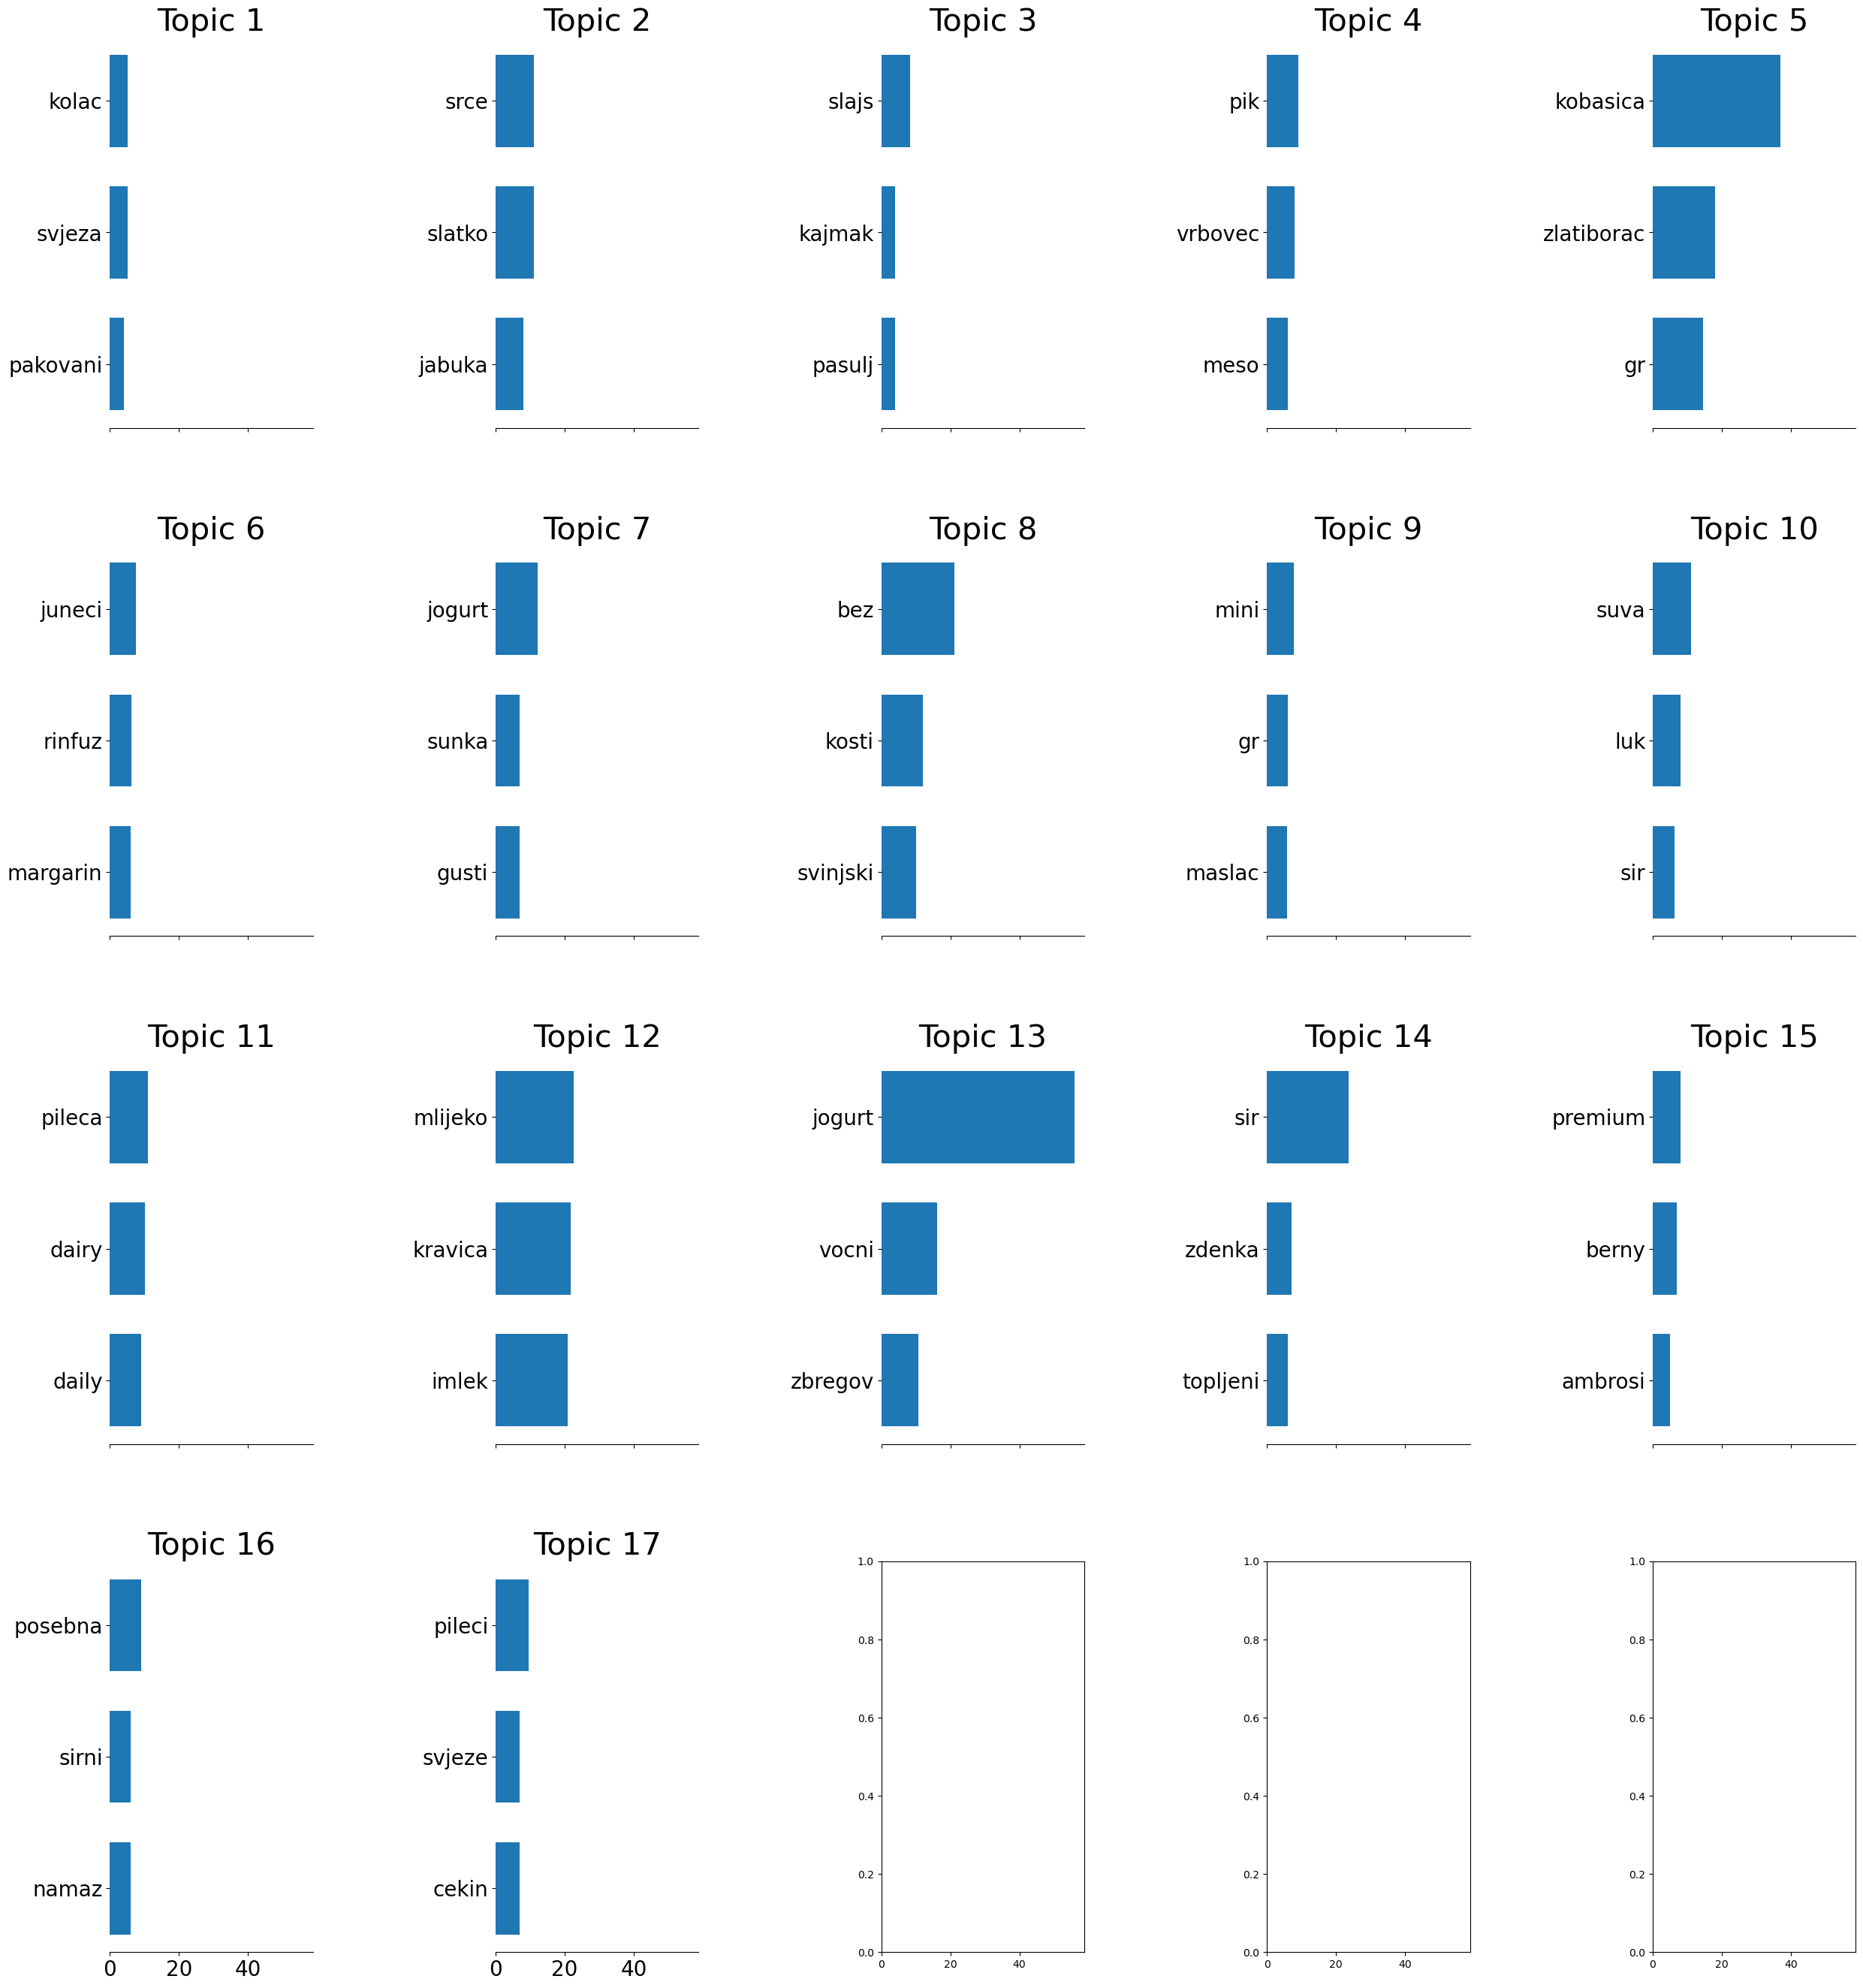

In [179]:
# although we have category names, here is LDA aka Latent Dirichlet Allocation
# "LDA can be very useful for large documents, such as news articles, 
# in uncovering its high level themes. However, it wasn’t quite right for 
# this data set as each food name isn’t necessarily made up of multiple topics."
# in the article on clustering products the number of 'topics' was found to be 30 and 5 words/topic
# in our case this looks as both values should be LESS (not more than 20 topics, manual categories are 17),
# not more than 3 w/topic (intuition)

#LDA

n_topics = 17
n_top_words = 3

lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=0.99)
X_lda = lda.fit(X_tot_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics

feature_names = vector_cv.get_feature_names_out()
plot_top_words(X_lda, feature_names, n_top_words, '')

# well, I'm not sure how to use it in this form, maybe it will be useful later...

In [181]:
#Fuzzywuzzy
text4 = pd.Series(text3)
X_fuzz = pd.crosstab([text4.index,text4],text4).apply(lambda col: [fuzz.token_sort_ratio(col.name, x) 
                                                                   for x in col.index.get_level_values(1)])
X_fuzz

,col_0,ananas,avokado komad,baby rotkvica,badem,badem rinfiuz,baget aroma s,baget tamni aroma s,bajadera slatko srce,balans imuno tt imlek,banana,...,ćureći file od prsiju pakovano smrznuto vindon,čajna kobasica,čupavci slatko srce,đumbir,đumbir suvi premium berny,šargarepa,šargarepa pakovana,škembići u paradajz sosu gr,štrudla trivit sa makom,šunka pileća pizza
row_0,row_1,,,,,,,,,,,,,,,,,,,,,
0,suva svinjska pecenica matijevic slajs,23,24,24,9,24,24,32,34,27,23,...,36,35,35,9,35,17,29,31,30,39
1,panceta matijevic slajs,34,28,33,14,22,44,43,47,27,28,...,29,38,33,14,25,25,34,28,43,34
2,pršuta slajs martex,32,25,31,17,31,38,37,46,25,24,...,25,30,32,16,32,36,27,35,43,32
3,suvi vrat martex,18,28,41,19,28,34,40,33,32,18,...,29,33,40,27,44,32,29,28,46,29
4,sunka pik vrbovec fina,29,29,34,15,23,29,24,33,37,29,...,38,28,39,14,38,26,35,29,36,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,domaća oblanda slatko srce,31,36,31,26,26,46,40,70,38,31,...,33,35,49,19,24,23,41,34,37,27
570,vanilice slatko srce,23,30,36,16,30,30,41,55,34,23,...,33,41,72,8,31,28,37,26,42,26
571,ruske kape slatko srce,21,29,34,15,29,40,34,71,33,14,...,35,28,54,14,34,32,35,29,36,30


In [171]:
print(X_tot_cv.shape) # just curious, what is the size of the result
print(X_tot_ntf.shape) # just curious, what is the size of the result
# first try just count vectorizer without Tfidf Transformer 
# (the latter reduces weight of frequent words but in our case I have no idea, which words might
# be lowered in weight, may be, mass/volume specified in the product name, but we might 
# cut it off in advance, I think it would be better)

Y_tot = df.category

(574, 572)
(574, 1485)


In [31]:
product_categ_clf_NB = MultinomialNB() # created the classifyer
